# Computing SNR for diffusion-weighted imaging
The following examples illustrate some basic SNR calculations on diffusion-weighted images (DWIs). The basic procedure is:

1. Correct for motion and for eddy current distortion, if necessary (i.e., if using single spin echo DWI; we use FSL's 'eddy')

2. For all the b=0 images, compute the standard deviation of each voxel. This will generate a noise map, but the map will be both biased and unreliable, due to the fact that there are only a few values used to estimate the stdev.

3. Correct the bias using the following estimate (see https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation):

$$ \sigma_{corrected} = \frac{\sigma}{\sqrt{ \frac{2}{n-1} }  \cdot \frac{ \Gamma(n/2) }{ \Gamma( \frac{n-1}{2} ) }  \>}$$
    

4. Correct the unreliability by averaging the stdev estimates across voxels. For a single average noise estimate take the mean stdev of all the voxels in a mask. For a map of noise estimates, apply heavy smoothing. (Both are used below.)

5. For SNR of the non-DWIs (b=0 images), take the mean of all b0 images and divide by the noise estimate

6. For DWI SNR it's a little less clear what's best. A simple option is to use max across all the DWIs. That works OK for data with relatively high SNR, but could really over-estimate SNR for data where the true SNR is low. This is something I think we should discuss and try to come up with a better metric.


In [48]:
%matplotlib inline
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
# ip_utils is available from: https://gist.github.com/rfdougherty/be3cb6f46eb1c483cc80
import ip_utils
from scipy.special import gamma
from scipy.ndimage.filters import gaussian_filter

# Which slices to show in the 3-axis view:
sl = [35,47,36]
# Smoothing to be applied to the snr maps
fwhm = 3
sigma = fwhm / 2.35482


In [49]:
def snr_bias_correction(n):
    return np.sqrt(2. / (n-1)) * (gamma(n / 2.) / gamma((n-1) / 2.))

def compute_snr(nifti_basename):
    ni = nb.load(nifti_basename+'.nii.gz')
    affine = ni.get_affine()
    d = ni.get_data()
    bvals = np.loadtxt(nifti_basename+'.bval')
    b0 = bvals<10
    n = b0.sum()
    noise = d[...,b0].std(axis=3, ddof=1) / snr_bias_correction(n)
    b0_sig = d[...,b0].mean(axis=3)

    noise_sm = gaussian_filter(noise, sigma)

    b0_sig_sm = gaussian_filter(b0_sig, sigma)
    b0_snr = b0_sig_sm / noise_sm
    
    # What to use to estimate the DWI 'signal'? 
    # * max will typically over-estimate SNR, possibly quite severly for data with a low (true) SNR.
    # * mean will underestimate and will be affected by the number of DW directions. E.g., for two 
    #   otherwise identical scans, one with twice as many directions may appear to have lower snr
    #   because the mean is brought down by including more low-signal measures.
    dwi_sig = d[...,b0==0].mean(axis=3)
    dwi_sig_sm = gaussian_filter(dwi_sig, sigma)
    dwi_snr = dwi_sig_sm / noise_sm
    
    return noise_sm,b0_sig,b0_snr,dwi_sig,dwi_snr,affine

def show_snr_maps(nifti_basename, mask, figsize=(14,4)):
     # wm_thresh: Percentile for thresholding mean dwi maps to get a crude WM mask. Higher values give smaller masks.
    
    noise_sm,b0_sig,b0_snr,dwi_sig,dwi_snr,affine = compute_snr(nifti_basename)
    b0_mean_snr = b0_snr[mask==1].mean()
    dwi_mean_snr = dwi_snr[mask==1].mean()

    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nb.Nifti1Image(b0_sig,affine), sl=sl, fig=fig, cmap='gray')
    plt.colorbar().set_label('Signal (arb.)', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('Mean b=0 image')

    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nb.Nifti1Image(noise_sm,affine), sl=sl, fig=fig, cmap='hot')
    plt.colorbar().set_label('Standard Deviation', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('Smoothed noise map')

    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nb.Nifti1Image(b0_snr,affine), sl=sl, fig=fig, cmap='hot')
    plt.colorbar().set_label('SNR', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('SNR for b=0 (mean SNR=%0.2f)' % b0_mean_snr)
    
    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nb.Nifti1Image(dwi_sig,affine), sl=sl, fig=fig, cmap='gray')
    plt.colorbar().set_label('Signal (arb.)', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('Mean dwi image')

    fig = plt.figure(figsize=figsize)
    ip_utils.show_brain(nb.Nifti1Image(dwi_snr,affine), sl=sl, fig=fig, cmap='hot')
    plt.colorbar().set_label('SNR', rotation=270, verticalalignment='center', fontsize=14)
    plt.title('SNR for DWIs (mean SNR=%0.2f)' % dwi_mean_snr)

    return b0_mean_snr,dwi_mean_snr

# Create a WM mask using the b=7k data
This mask will be used to compute the mean SNR for each of the b-value scans. Using a common mask makes them comparable.

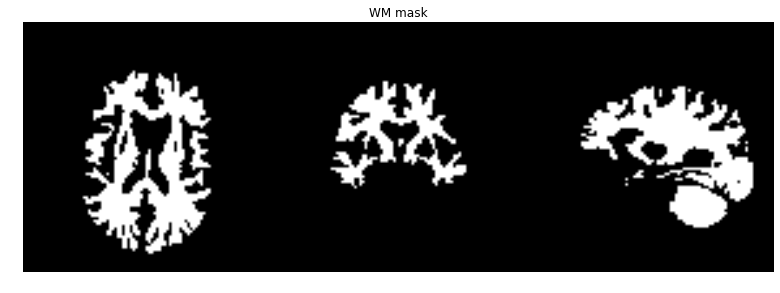

In [50]:
noise_sm,b0_sig,b0_snr,dwi_sig,dwi_snr,affine = compute_snr('/predator-scratch/upitt/s002_abs/b7k_dwi_ec')
brain_mask = nb.load('/predator-scratch/upitt/s002_abs/b7k_b0_corrected_mask.nii.gz').get_data()
# Very crude WM mask
mask = np.logical_and(dwi_sig>np.percentile(dwi_sig, 90), brain_mask).astype(int)

fig = plt.figure(figsize=(14,4))
d,clip = ip_utils.prep_brain(nb.Nifti1Image(mask,affine))
ip_utils.plot_brain(ip_utils.three_axis(d, sl=sl), cmap='gray', clip=clip, fig=fig)
plt.title('WM mask')

# SNR maps for b=7k
The b=7k b0 image has higher signal magnitude than b0 images from lower b-values, despite the longer TE. It also has better tissue contrast. Both of these are due to the fact that the longer TE of the high b-value scans necessitates a longer TR. For the Stanford protocol, the TRs are short enough that small changes can have a substantial effect on signal levels.

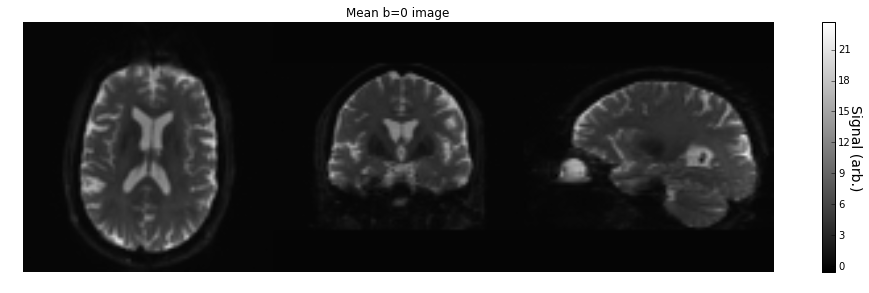

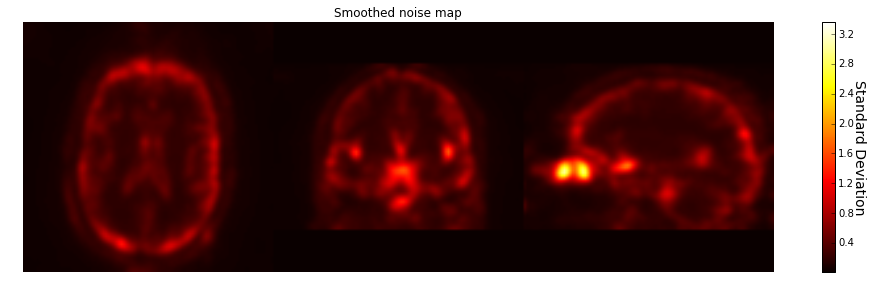

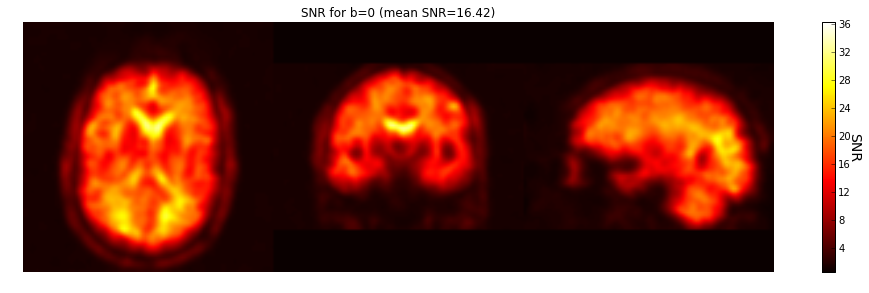

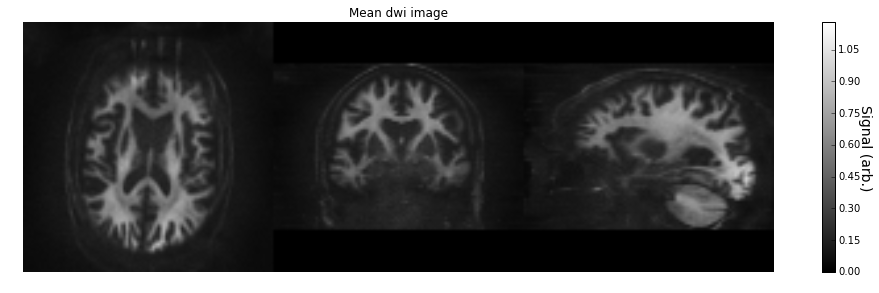

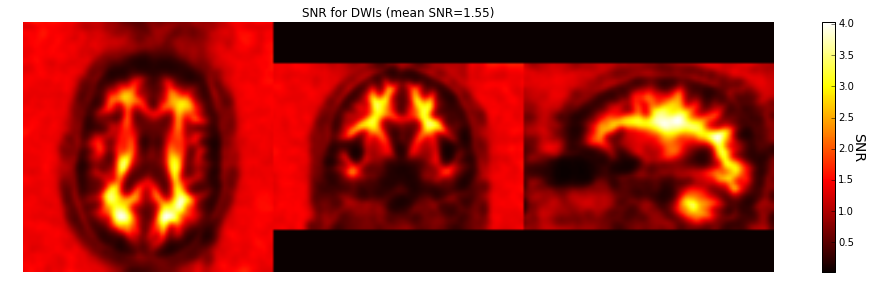

In [51]:
snr_mean = {}
snr_mean[7] = show_snr_maps('/predator-scratch/upitt/s002_abs/b7k_dwi_ec', mask)

# SNR maps for b=5k

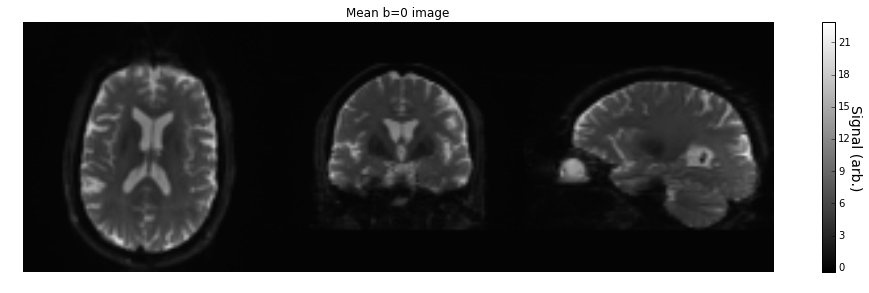

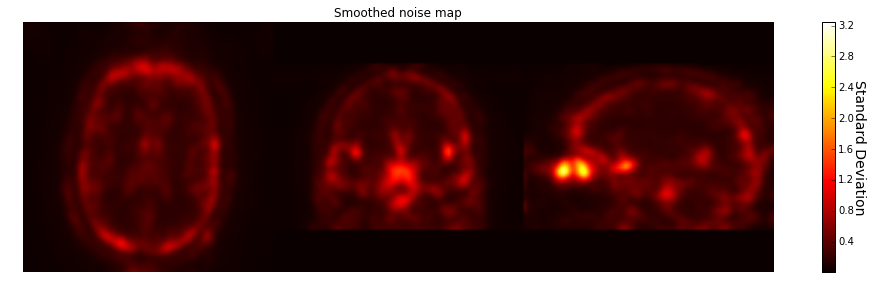

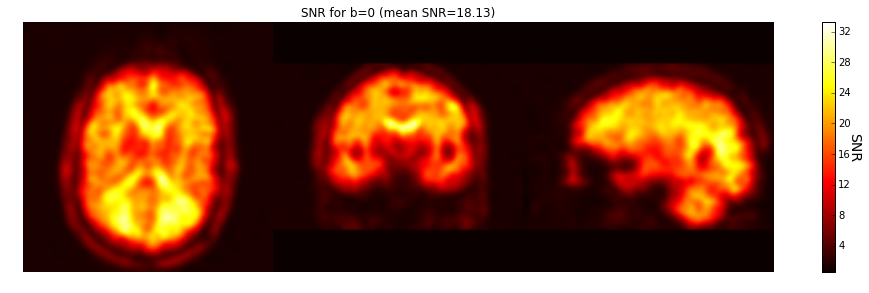

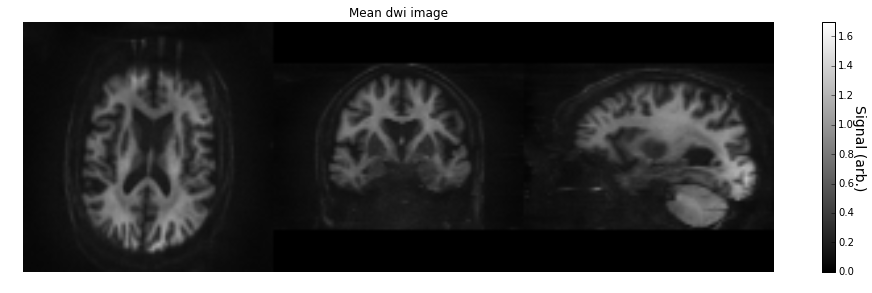

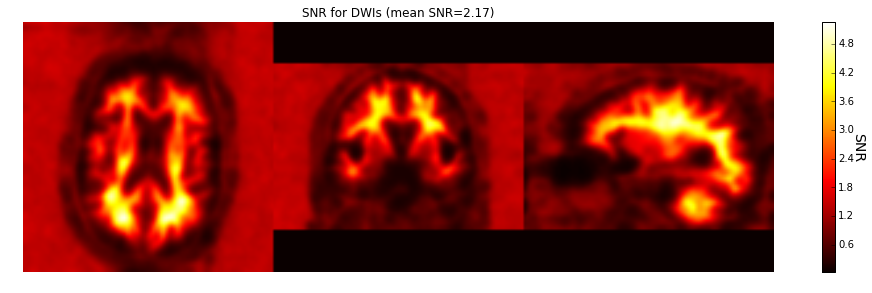

In [52]:
snr_mean[5] = show_snr_maps('/predator-scratch/upitt/s002_abs/b5k_dwi_ec', mask)

# SNR maps for b=3k

In [1]:
snr_mean[3] = show_snr_maps('/predator-scratch/upitt/s002_abs/b3k_dwi_ec', mask)

NameError: name 'show_snr_maps' is not defined

# SNR maps for b=1k

In [2]:
snr_mean[1] = show_snr_maps('/predator-scratch/upitt/s002_abs/b1k_dwi_ec', mask)

NameError: name 'show_snr_maps' is not defined

In [55]:
for b in sorted(snr_mean):
    print "b%0.0fK: b0 SNR=%5.2f, dwi SNR=%5.2f" % ((b,)+snr_mean[b])

b1K: b0 SNR=34.91, dwi SNR=15.89
b3K: b0 SNR=29.39, dwi SNR= 5.43
b5K: b0 SNR=18.13, dwi SNR= 2.17
b7K: b0 SNR=16.42, dwi SNR= 1.55


## Notes

* **Mean SNR:** Using a high-quality white matter mask for the mean SNR calculation would be better.
* **DWI SNR:** How to estimate the DWI 'signal' for computing DWI SNR maps? Max will typically over-estimate SNR, possibly quite severly for data with a low (true) SNR. Mean may underestimate and will be affected by the number of DW directions. E.g., for two otherwise identical scans, one with twice as many directions may appear to have lower snr because the mean is brought down by including more low-signal measures.

# Explore

In [57]:
mask = nb.load('/predator-scratch/upitt/s002_abs/b7k_b0_corrected_mask.nii.gz').get_data()
noise_sm,b0_sig,b0_snr,dwi_sig,dwi_snr,affine = compute_snr('/predator-scratch/upitt/s002_abs/b7k_dwi_ec')
